In [2]:
import torch
from torch.utils.data import DataLoader
from datasets.cfg import num_classes, max_size
from models.models import build_model
from datasets.loader import DataModule, DataConfig
from datasets.base import collate_bb
from train.eval import Evaluator
from train.unsupervised_metrics import UnlabeledSanity

device = torch.device("cuda")

#model_B = build_model("maskrcnn_r50_fpn", num_classes).to(device)
#model_B.load_state_dict(torch.load("./weights/maskrcnn_B_ep40.pth", map_location="cuda"))

#model_AB = build_model("maskrcnn_r50_fpn", num_classes).to(device)
#model_AB.load_state_dict(torch.load("./weights/maskrcnn_AB_ep40.pth", map_location="cuda"))

data = DataModule(DataConfig())
loader_B_test = data.make_loader_b_test()
loader_A_val  = data.make_loader_a_val()
loader_C_test  = data.make_loader_c_test()

In [1]:
import mlflow

mlflow.set_tracking_uri("file:///media/sdb1/mlflow")
m = mlflow.pyfunc.load_model("runs:/515d2185a4fb4e67a511ace7db4566af/model")

2025/12/12 07:21:00 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - jaraco-collections (current: uninstalled, required: jaraco-collections==5.1.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [5]:
import mlflow.pytorch

model_uri = "file:///media/sdb1/mlflow/899739375711377081/515d2185a4fb4e67a511ace7db4566af/artifacts/model"
pt = mlflow.pytorch.load_model(model_uri)
m = pt

In [7]:
e = Evaluator(device)
mb_B  = e.metrics_masks(m,  loader_B_test, num_classes=num_classes - 1)

rows = [
    ["setup", "mAP50", "PQ_all", "mPQ", "AJI"],
    ["Model B", f"{mb_B['mAP50']:.3f}",  f"{mb_B['PQ_all']:.3f}",  f"{mb_B['mPQ']:.3f}",  f"{mb_B['AJI']:.3f}"],
]
print("\n=== B-test metrics ===")
e.print_table(rows)

map50_A_val = e.map50(m, loader_A_val)
print(f"\nA-val mAP50 (boxes, A+B model): {map50_A_val:.3f}")

map50_C = e.map50(m, loader_C_test)
print(f"\nChromo-CRCN test mAP50 (boxes, A+B model): {map50_C:.3f}")


=== B-test metrics ===
setup    mAP50  PQ_all  mPQ    AJI  
Model B  0.915  0.648   0.645  0.593

A-val mAP50 (boxes, A+B model): 0.955

Chromo-CRCN test mAP50 (boxes, A+B model): -1.000


In [10]:

model_AB = m
loader_D_test  = data.make_loader_d_test()

In [11]:
sanity = UnlabeledSanity(num_classes=24)
san_scores_ab_b = e.sanity(model_AB, loader_B_test, sanity)
san_scored_ab_d = e.sanity(model_AB, loader_D_test, sanity)

In [12]:
r0 = san_scores_ab_b["per_image"][0] #sanity for one image
print("AB model: image 0 -> n:", r0.n_instances, "sex:", r0.sex_pattern)



ds = san_scores_ab_b["dataset_scores"]
print("\n=== Unlabeled B-test sanity (A+B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

ds = san_scored_ab_d["dataset_scores"]
print("\n=== Unlabeled D-test sanity (A+B model) ===")
print("total:", f"{ds['total']:.3f}",
      "count:", f"{ds['count']:.3f}",
      "balance:", f"{ds['class_balance']:.3f}",
      "sex:", f"{ds['sex']:.3f}",
      "size:", f"{ds['size']:.3f}")

AB model: image 0 -> n: 100 sex: XY

=== Unlabeled B-test sanity (A+B model) ===
total: 0.671 count: 0.518 balance: 0.554 sex: 0.675 size: 0.936

=== Unlabeled D-test sanity (A+B model) ===
total: 0.733 count: 0.565 balance: 0.615 sex: 0.823 size: 0.930



Examples: B-test, A+B model


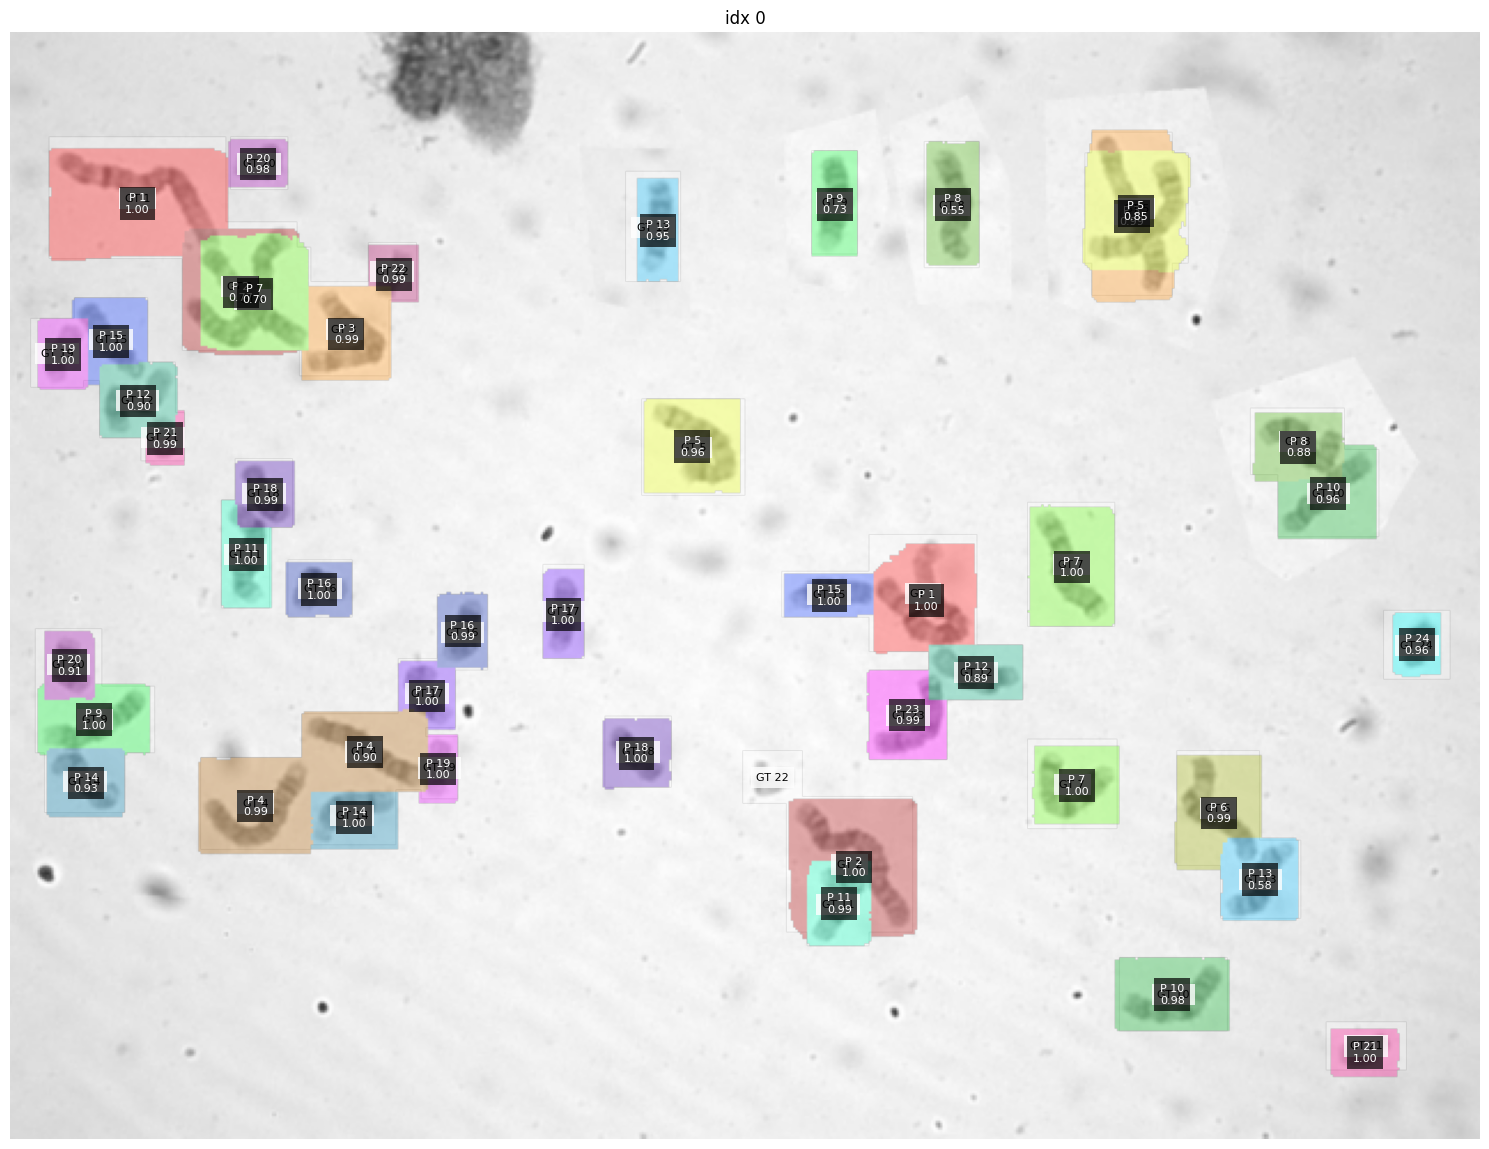

In [18]:
e.show_examples(data.ds_a_val, model_AB, n=1, score_thresh=0.5, title="B-test, A+B model")

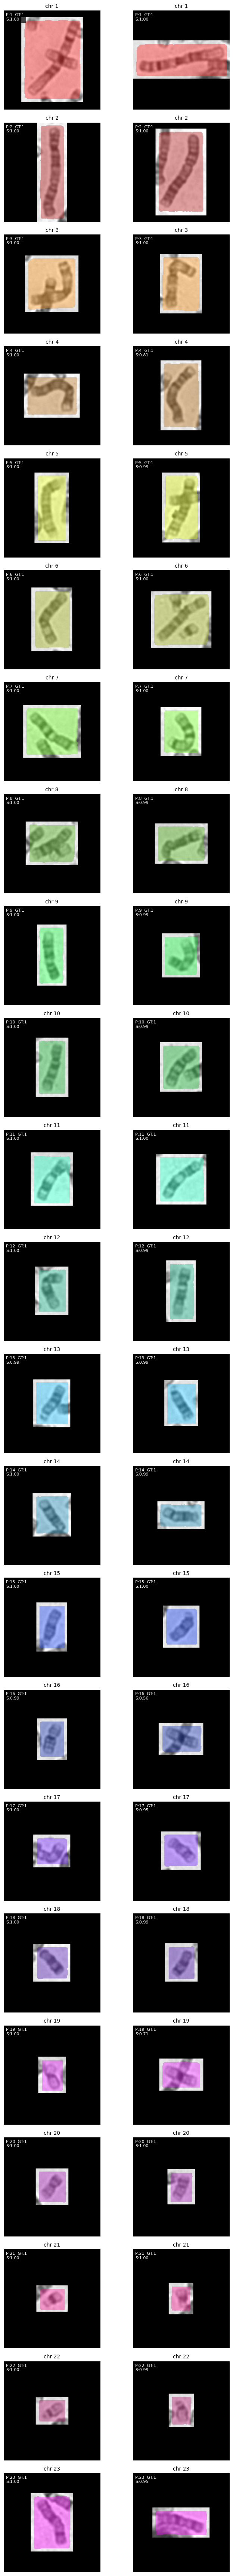

In [19]:

from train.karyo_plotting4 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=1, score_thresh=0.5, pad=5):
    model.eval()
    img_t, target = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, target, idx=idx, score_thresh=score_thresh, pad=pad)

plot_karyogram_from_dataset(data.ds_d_test, model_AB, idx=2)

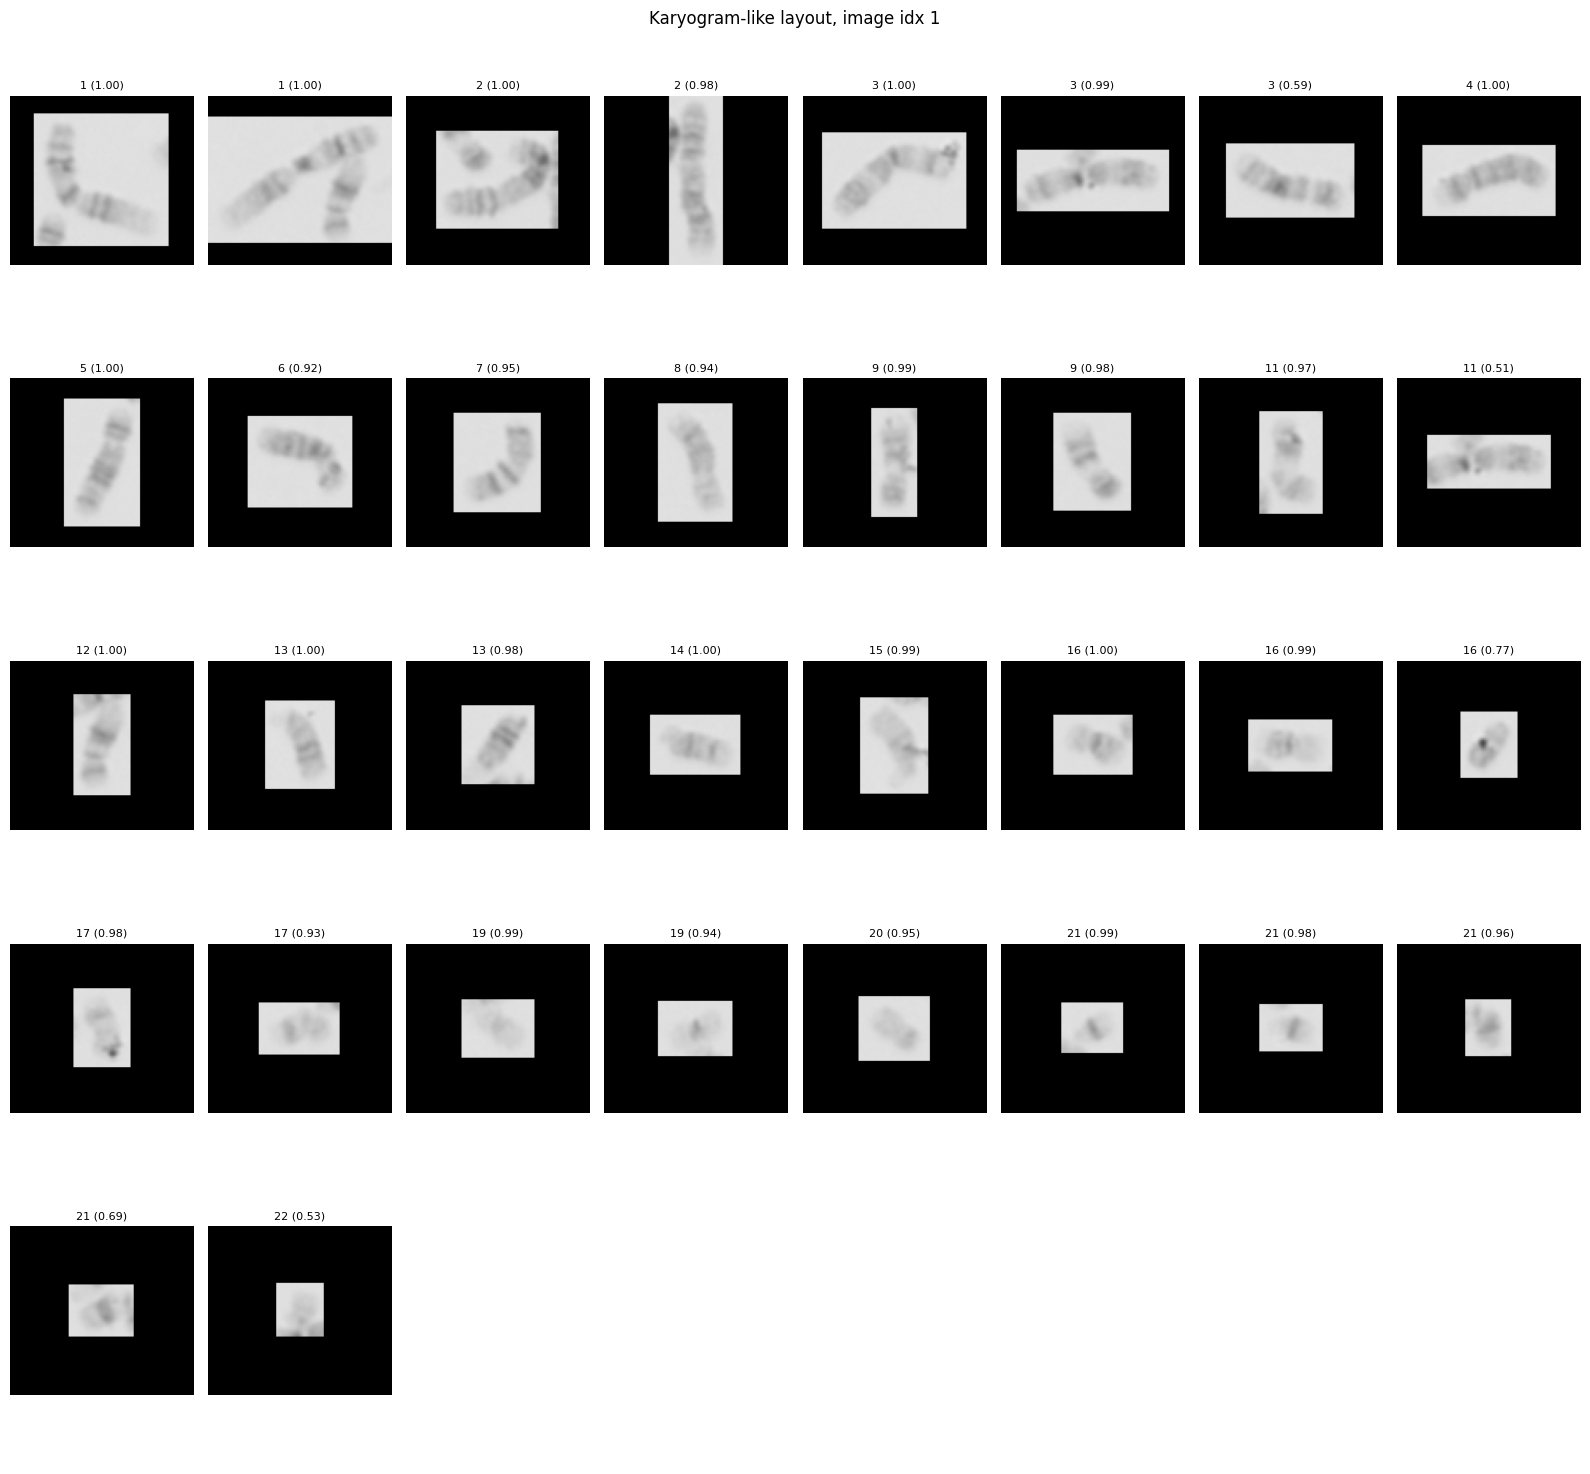

In [14]:
from train.karyo_plotting2 import plot_karyogram_from_output

def plot_karyogram_from_dataset(dataset, model, idx=0, score_thresh=0.5,pad=5,cols=8):
    model.eval()
    img_t, _ = dataset[idx]
    img_t = img_t.to(device)

    with torch.no_grad():
        out = model([img_t])[0]

    plot_karyogram_from_output(img_t.cpu(), out, idx, score_thresh, pad, cols)

plot_karyogram_from_dataset(data.ds_b_test, model_AB, idx= 1)